# StrategicGrowthAnalysis-UniqueGiftsLtd

In [2]:
import requests # for downloading the dataset
import os # for file operations
from tqdm import tqdm  # progress bar library

url = "https://docs.google.com/spreadsheets/d/1RZ0nYqAUgSivbfIiMsbZfEy2yg5KzNBcbGThzDPHx7c/export?format=csv"
file_path = "../data/dataset.csv" # Path to save the dataset

os.makedirs("../data", exist_ok=True)

response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))
block_size = 1024  # 1 KB

print("Downloading dataset with progress:")

with open(file_path, "wb") as file, tqdm(
    desc=file_path,
    total=total_size,
    unit='iB',
    unit_scale=True,
    unit_divisor=1024,
) as bar:
    for data in response.iter_content(block_size):
        file.write(data)
        bar.update(len(data))

print("Download complete!")



../data/dataset.csv: 89.7MiB [01:58, 791kiB/s] 

Download complete!


create a function to load the dataset

In [3]:
import pandas as pd

if not os.path.exists(file_path): # Check if the file exists
    raise FileNotFoundError(f"Dataset file not found at {file_path}. Please check the download process.")

df = pd.read_csv(file_path) # Load the dataset
print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")


Dataset loaded successfully with 1067371 rows and 8 columns.


your task is to analyze the dataset and provide insights on how UniqueGiftsLtd can strategically grow its business.

In [4]:
# Display the first few rows of the dataset
try:
    df = pd.read_csv('../data/dataset.csv')  # Adjust the path as necessary
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'online_retail.csv' was not found in the 'data' folder.")
    print("Please make sure you have downloaded the dataset and placed it in the correct folder.")

# Display the first 5 rows to get an idea of the data
df.head()

Dataset loaded successfully!


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Have fun creating your demo method using the dataset (df)! 🚀📊😊

In [5]:
print("Dataframe Info:")
df.info()

print("\n" + "="*50 + "\n")

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB




In [6]:
# Get summary statistics for numerical columns
print("Numerical Describe:")
print(df.describe())
print("\n" + "="*50 + "\n")

Numerical Describe:
           Quantity         Price    Customer ID
count  1.067371e+06  1.067371e+06  824364.000000
mean   9.938898e+00  4.649388e+00   15324.638504
std    1.727058e+02  1.235531e+02    1697.464450
min   -8.099500e+04 -5.359436e+04   12346.000000
25%    1.000000e+00  1.250000e+00   13975.000000
50%    3.000000e+00  2.100000e+00   15255.000000
75%    1.000000e+01  4.150000e+00   16797.000000
max    8.099500e+04  3.897000e+04   18287.000000




In [7]:
# Count missing values in each column
print("Missing Values Count:")
print(df.isnull().sum())


Missing Values Count:
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


# Handle Duplicates & Missing Data)

In [8]:
# Print shape before dropping duplicates
print(f"Shape before dropping duplicates: {df.shape}")

print(df.duplicated().sum())

# Drop duplicate rows
df.drop_duplicates(inplace=True) # re df

# Print shape after dropping duplicates
print(f"Shape after dropping duplicates: {df.shape}")

# Drop rows where Customer ID is missing
df.dropna(subset=['Customer ID'], inplace=True)

# Print shape after dropping missing Customer ID
print(f"Shape after dropping duplicates: {df.shape}")

# Verify that missing Customer IDs are handled
print("\nMissing values after handling Customer ID:")
print(df.isnull().sum())

Shape before dropping duplicates: (1067371, 8)
34335
Shape after dropping duplicates: (1033036, 8)
Shape after dropping duplicates: (797885, 8)

Missing values after handling Customer ID:
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


# Clean Transactional Data

In [9]:
# Remove cancelled orders (Invoice starts with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Ensure quantity is positive
df = df[df['Quantity'] > 0]

# Remove records where price is 0
df = df[df['Price'] > 0]

# Check the shape of the dataframe after cleaning
print(f"Shape after cleaning transactions: {df.shape}")


Shape after cleaning transactions: (779425, 8)


# Filtering Non-Product Charges

In [11]:
# (Assuming 'df' is your dataframe after the initial cleaning)

def is_product_code(code):
    """
    Checks if a stock code is likely a product by seeing if it contains any digit.
    Returns True if it contains a digit, False otherwise.
    e.g., is_product_code('85123A') -> True
           is_product_code('POST')    -> False
    """
    code_str = str(code)
    return any(char.isdigit() for char in code_str)
    # ====================


# --- Identify codes that would be removed using this new logic ---
all_unique_codes = df['StockCode'].unique()
codes_to_be_removed = [code for code in all_unique_codes if not is_product_code(code)]
print(f"Following codes (without any digits) will be removed: {codes_to_be_removed}")


# --- Filtering Step ---
print(f"\nShape before filtering: {df.shape}")

# Apply the function to the 'StockCode' column and keep only the rows that return True
df = df[df['StockCode'].apply(is_product_code)]

print(f"Shape after filtering: {df.shape}")


Following codes (without any digits) will be removed: []

Shape before filtering: (776840, 8)
Shape after filtering: (776840, 8)


# Create TotalPrice column


In [12]:
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

print(df.shape)
print(df.head())

(776840, 9)
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  TotalPrice  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom        83.4  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom       100.8  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom        30.0  


# Convert InvoiceDate to datetime


In [13]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(type(df['InvoiceDate']))
print(df['InvoiceDate'].dtype)

# 2. නව columns 4ක් සාදන්න - Year, Month, DayOfWeek, HourOfDay
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek     # Monday=0, Sunday=6
df['HourOfDay'] = df['InvoiceDate'].dt.hour

# 3. බලන්න කොහොම තියෙනද (මුල් 5 rows)
print(df[['InvoiceDate', 'Year', 'Month', 'DayOfWeek', 'HourOfDay']].head())


<class 'pandas.core.series.Series'>
datetime64[ns]
          InvoiceDate  Year  Month  DayOfWeek  HourOfDay
0 2009-12-01 07:45:00  2009     12          1          7
1 2009-12-01 07:45:00  2009     12          1          7
2 2009-12-01 07:45:00  2009     12          1          7
3 2009-12-01 07:45:00  2009     12          1          7
4 2009-12-01 07:45:00  2009     12          1          7


# Convert Customer ID to integer
# Convert Customer ID to integer


In [15]:

df['Customer ID'] = df['Customer ID'].astype(int)  # Convert Customer ID to integer

print(df['Customer ID'].dtype)


int64


# Convert StockCode to string


In [16]:
# Convert StockCode to string
df['StockCode'] = df['StockCode'].astype(str)  # Convert StockCode to string
print(df['StockCode'].dtype)

object


# create cleaned dataset - .csv file

In [17]:
df.to_csv('../data/cleaned-dataset.csv', index=False)


In [ ]:
# start code with me

#  Exploratory Data Analysis (EDA) & Insight Generation

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Dataset load (Cleaned dataset)
df = pd.read_csv('../data/cleaned-dataset.csv')

print("Dataset loaded successfully!")


Dataset loaded successfully!


# Temporal Analysis

0        2009-12-01 07:45:00
1        2009-12-01 07:45:00
2        2009-12-01 07:45:00
3        2009-12-01 07:45:00
4        2009-12-01 07:45:00
                 ...        
776835   2011-12-09 12:50:00
776836   2011-12-09 12:50:00
776837   2011-12-09 12:50:00
776838   2011-12-09 12:50:00
776839   2011-12-09 12:50:00
Name: InvoiceDate, Length: 776840, dtype: datetime64[ns]
InvoiceDate converted to datetime.
0    2009-12
1    2009-12
2    2009-12
3    2009-12
4    2009-12
Name: YearMonth, dtype: period[M]
  YearMonth  TotalPrice
0   2009-12   678379.57
1   2010-01   533952.98
2   2010-02   498137.57
3   2010-03   666373.67
4   2010-04   585499.93


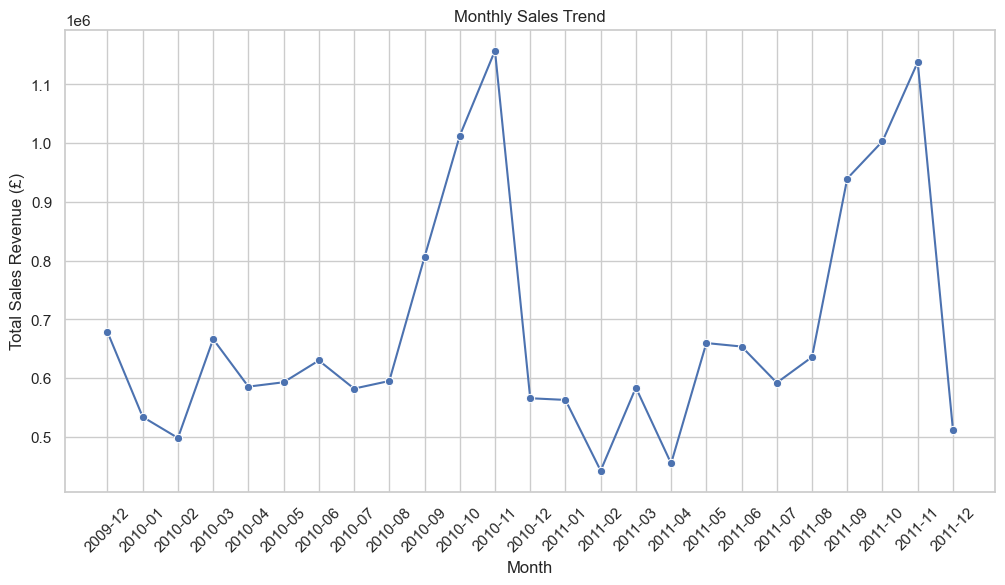

In [20]:
# Year-Month column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df['InvoiceDate'])
print("InvoiceDate converted to datetime.")
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
print(df['YearMonth'].head())  # Display first few YearMonth values

# Group by Year-Month and sum TotalPrice
monthly_sales = df.groupby('YearMonth')['TotalPrice'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)  # Convert YearMonth to string for plotting
print(monthly_sales.head())  # Display first few rows of monthly sales data

# Line chart Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='YearMonth', y='TotalPrice', data=monthly_sales, marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales Revenue (£)")
plt.xticks(rotation=45)
plt.show()



# Temporal Analysis – February & April Drops Check

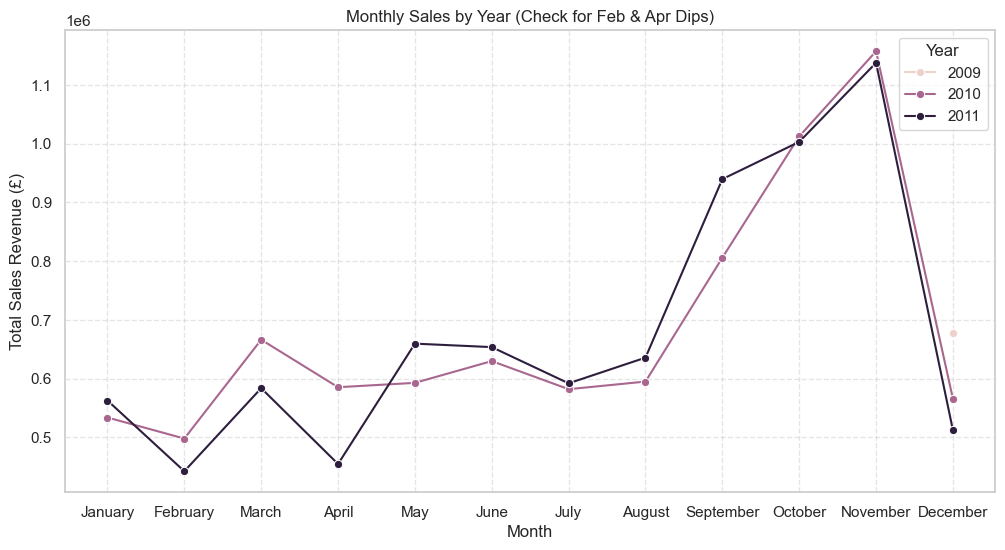

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract Year and Month from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['MonthName'] = df['InvoiceDate'].dt.strftime('%B')

# Group by Year and MonthName to get total sales
monthly_sales_yearly = df.groupby(['Year', 'MonthName'])['TotalPrice'].sum().reset_index()

# Reorder the months for better visualization
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
monthly_sales_yearly['MonthName'] = pd.Categorical(monthly_sales_yearly['MonthName'], 
                                                   categories=month_order, 
                                                   ordered=True)
monthly_sales_yearly = monthly_sales_yearly.sort_values(['Year', 'MonthName'])

# Plotting the monthly sales by year
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales_yearly, x='MonthName', y='TotalPrice', hue='Year', marker='o')
plt.title("Monthly Sales by Year (Check for Feb & Apr Dips)")
plt.xlabel("Month")
plt.ylabel("Total Sales Revenue (£)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Temporal Analysis – Day & Hour Pattern

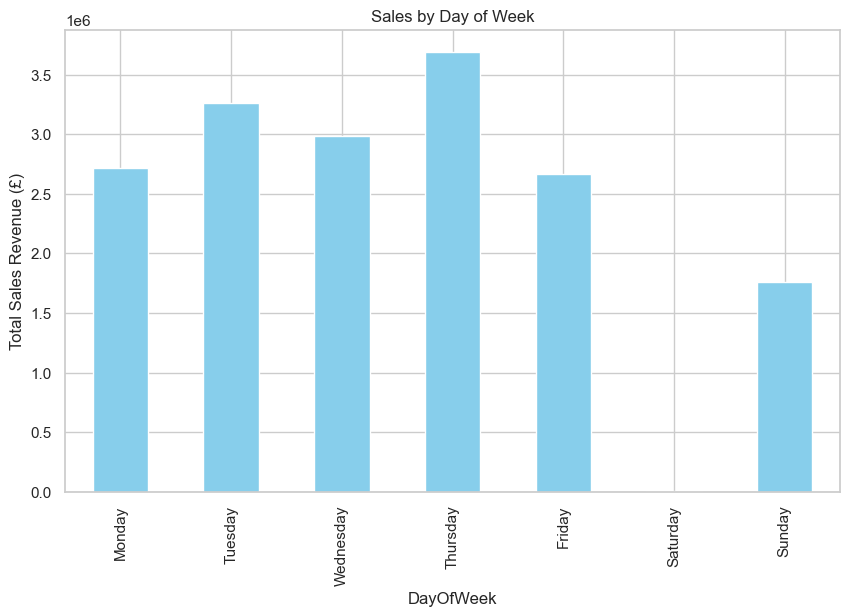

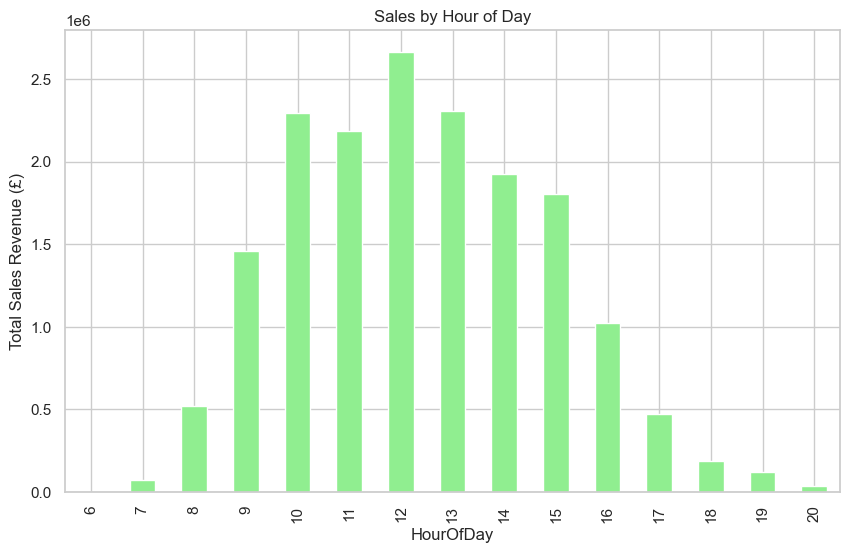

In [28]:
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['HourOfDay'] = df['InvoiceDate'].dt.hour

# Sales by Day
sales_by_day = df.groupby('DayOfWeek')['TotalPrice'].sum().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

# Bar chart – Day
sales_by_day.plot(kind='bar', color='skyblue')
plt.title("Sales by Day of Week")
plt.ylabel("Total Sales Revenue (£)")
plt.show()

# Sales by Hour
sales_by_hour = df.groupby('HourOfDay')['TotalPrice'].sum()
sales_by_hour.plot(kind='bar', color='lightgreen')
plt.title("Sales by Hour of Day")
plt.ylabel("Total Sales Revenue (£)")
plt.show()


# Geographic Analysis – Top 10 Countries

C:\Users\malka\AppData\Local\Temp\ipykernel_7004\1763546929.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalPrice', y='Country', data=top_10_countries, palette="viridis")


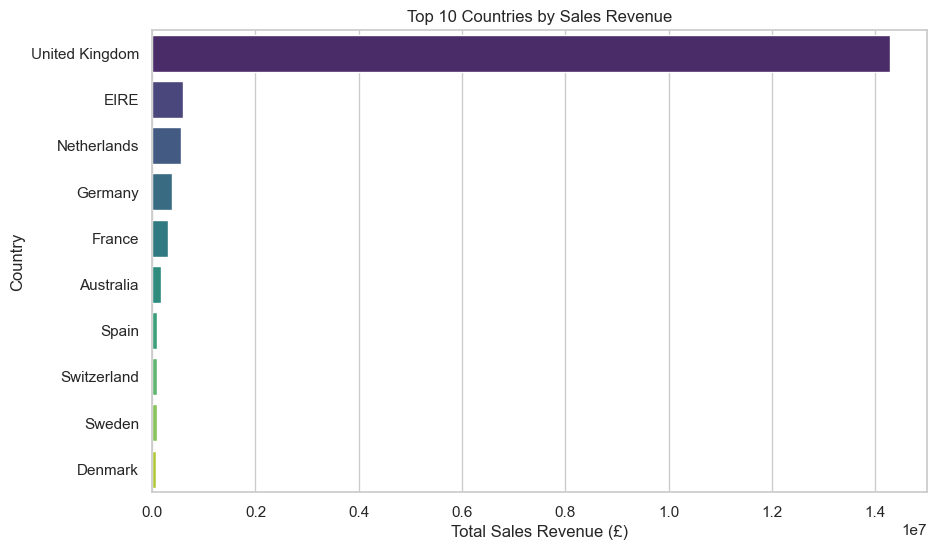

In [29]:
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).reset_index()

# Top 10
top_10_countries = country_sales.head(10)

# Plot
sns.barplot(x='TotalPrice', y='Country', data=top_10_countries, palette="viridis")
plt.title("Top 10 Countries by Sales Revenue")
plt.xlabel("Total Sales Revenue (£)")
plt.ylabel("Country")
plt.show()


# Geographic Analysis – UK vs Other Countries

In [30]:
uk_revenue = df[df['Country'] == 'United Kingdom']['TotalPrice'].sum()
total_revenue = df['TotalPrice'].sum()
uk_percentage = (uk_revenue / total_revenue) * 100
print(f"UK Revenue %: {uk_percentage:.2f}%")


UK Revenue %: 83.67%


# Product Performance Analysis

In [ ]:
# Top 10 by Quantity Sold
top_quantity = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Top 10 by Revenue
top_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

print("Top 10 by Quantity Sold:\n", top_quantity)
print("\nTop 10 by Revenue:\n", top_revenue)

# aa

Top 10 by Quantity Sold:
 Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     105185
WHITE HANGING HEART T-LIGHT HOLDER     91757
PAPER CRAFT , LITTLE BIRDIE            80995
ASSORTED COLOUR BIRD ORNAMENT          78234
MEDIUM CERAMIC TOP STORAGE JAR         77916
JUMBO BAG RED RETROSPOT                74224
BROCADE RING PURSE                     70082
PACK OF 60 PINK PAISLEY CAKE CASES     54592
60 TEATIME FAIRY CAKE CASES            52828
PACK OF 72 RETRO SPOT CAKE CASES       45129
Name: Quantity, dtype: int64

Top 10 by Revenue:
 Description
REGENCY CAKESTAND 3 TIER              277656.25
WHITE HANGING HEART T-LIGHT HOLDER    247048.01
PAPER CRAFT , LITTLE BIRDIE           168469.60
JUMBO BAG RED RETROSPOT               134307.44
ASSORTED COLOUR BIRD ORNAMENT         124351.86
PARTY BUNTING                         103283.38
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
PAPER CHAIN KIT 50'S CHRISTMAS         76598.18
CHILLI LIGHTS                          69084.30
JUMBO BAG STRAWBER